# 信贷项目

**项目背景：**


- 小微商户可以向平台贷款；
- 商户会存在逾期还款甚⾄不还款的⾏为。


**项目意义：**

减少贷款业务中出现坏账的可能性。

**项目目标：**


根据商户信息、信用记录和交易流⽔信息，预测该条贷款申请是否会出现30天逾期还款现象。

**数据集介绍：**
2018年4月-2018年6月，商户的交易流⽔数据、贷款数据、还款数据等。

商户数据：

- table_datamining_merchant.txt

| merchant_id     | industry_level1 | province |
|-----------------|-----------------|----------|
| 967197052907468 | 2               | 1        |



抛出点数据：

- table_throwpoint_training.txt
- table_throwpoint_test.txt
| store_id       | pt       |
|----------------|----------|
| 866722486898057| 20180501 |


流⽔数据：

- table_loss_transaction_trainingdata.txt
- table_loss_transaction_testdata.txt
- table_lend_transaction_final.txt
| id               | type | status | store_id       | merchant_id     | pay_way | sub_pay_way | paid_amount | ctime          | bankcard_credit | bankcard_debit | wallet_weixin | wallet_alipay | wallet_alipay_finance | alipay_huabei | alipay_point | pt       |
|------------------|------|--------|----------------|-----------------|---------|-------------|-------------|----------------|-----------------|----------------|---------------|---------------|------------------------|---------------|--------------|----------|
| t7895258038171778| 30   | 2000   | 152891338556931| 733274352303974 | 3       | 3           | 486         | 1523704560899  | 486             | 0              | 0             | 0             | 0                      | 0             | 0            | 20180414 |



历史还款数据：

- table_datamining_history_loan.txt
| apply_id | merchant_id     | apply_date           | lend_amount | lend_period | notional_settle_date | real_settle_date     | is_30days_overdue |
|----------|-----------------|----------------------|-------------|-------------|----------------------|----------------------|-------------------|
| 9664605  | 041973696425690 | 2017-03-08 00:00:00  | 20000.0     | 6           | 2017-09-10 00:00:00  | 2017-05-12 00:00:00  | 0                 |



贷款数据：

- table_loan_train.txt
| apply_id | merchant_id     | apply_date           | lend_amount | lend_period | is_30days_overdue |
|----------|-----------------|----------------------|-------------|-------------|-------------------|
| 53143959 | 408215340609460 | 2018-06-11 00:00:00  | 50000.0     | 12          | 0                 |


- table_loan_test.txt

| apply_id | merchant_id     | apply_date           | lend_amount | lend_period |
|----------|-----------------|----------------------|-------------|-------------|
| 50557025 | 040407382055696 | 2018-05-14 00:00:00  | 3000.0      | 12          |


### 特征提取

贷款申请

- 同一贷款人id 贷款次数、逾期30 天还款现象的贷款交易数、未逾期还贷频率、逾期率（逾期的次数与总贷款次数的比值）、是否出现最后还款期限内未还完的情况
（通过理论结清日和实际结清日判断）
- 实际还款和理论还款之间的天数差异
- 历史逾期率：商户历史逾期的次数占总贷款次数的比率
- 商户对应的有逾期30 天还款现象的次数（要通过计算理论结清日与实际结清日进行重新计算）、商户对应的没有出现逾期30 天还款现象的次数（要通过计算理论结清日与实际结清日进行重新计算）
- 商户逾期率与平均贷款期数的比值
- 商户历史贷款总金额、历史平均贷款期数、历史30 天逾期次数
- 每期应还款数（lend/amout）
- 还款金额统计特征：平均值、总额、最大值、最小值等

交易流水

- 商户平均每日消费者支付金额、平均每日红包金额
- 商户储蓄卡、微信余额、支付宝余额、支付宝余额宝的平均每日消费者支付金额，商户信用卡、花呗、集分宝的平均每日消费者支付金额
- 商户交易活动度（某段时间的交易次数、交易总金额、交易金额的标准差）
- 信用卡支付金额与总支付金额的比例、花呗支付金额与总支付金额的比例
- 支付方式统计（是否只用单一方式交易）、支付方式比例（不同支付方式的交易金额占比）
- 交易频率、交易金额统计特征（平均值、总额、最大值、最小值）

In [89]:
import pandas as pd
import numpy as np

# 加载数据集
merchant_data = pd.read_csv('data/table_datamining_merchant.txt')
throwpoint_training = pd.read_csv('data/table_throwpoint_training.txt')
throwpoint_test = pd.read_csv('data/table_throwpoint_test.txt')
transaction_training = pd.read_csv('data/table_loss_transaction_trainingdata.txt')
transaction_test = pd.read_csv('data/table_loss_transaction_testdata.txt')
transaction_final = pd.read_csv('data/table_lend_transaction_final.txt')
history_loan = pd.read_csv('data/table_datamining_history_loan.txt')
loan_train = pd.read_csv('data/table_loan_train.txt')
loan_test = pd.read_csv('data/table_loan_test.txt')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5525 entries, 0 to 5524
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   merchant_id                      5525 non-null   int64  
 1   avg_daily_amount                 5525 non-null   float64
 2   avg_daily_red_packet             5525 non-null   float64
 3   avg_daily_bankcard_credit        5525 non-null   float64
 4   avg_daily_bankcard_debit         5525 non-null   float64
 5   avg_daily_wallet_weixin          5525 non-null   float64
 6   avg_daily_wallet_alipay          5525 non-null   float64
 7   avg_daily_wallet_alipay_finance  5525 non-null   float64
 8   avg_daily_alipay_huabei          5525 non-null   float64
 9   avg_daily_alipay_point           5525 non-null   float64
 10  transaction_count                5525 non-null   int64  
 11  transaction_sum_x                5525 non-null   float64
 12  transaction_std     

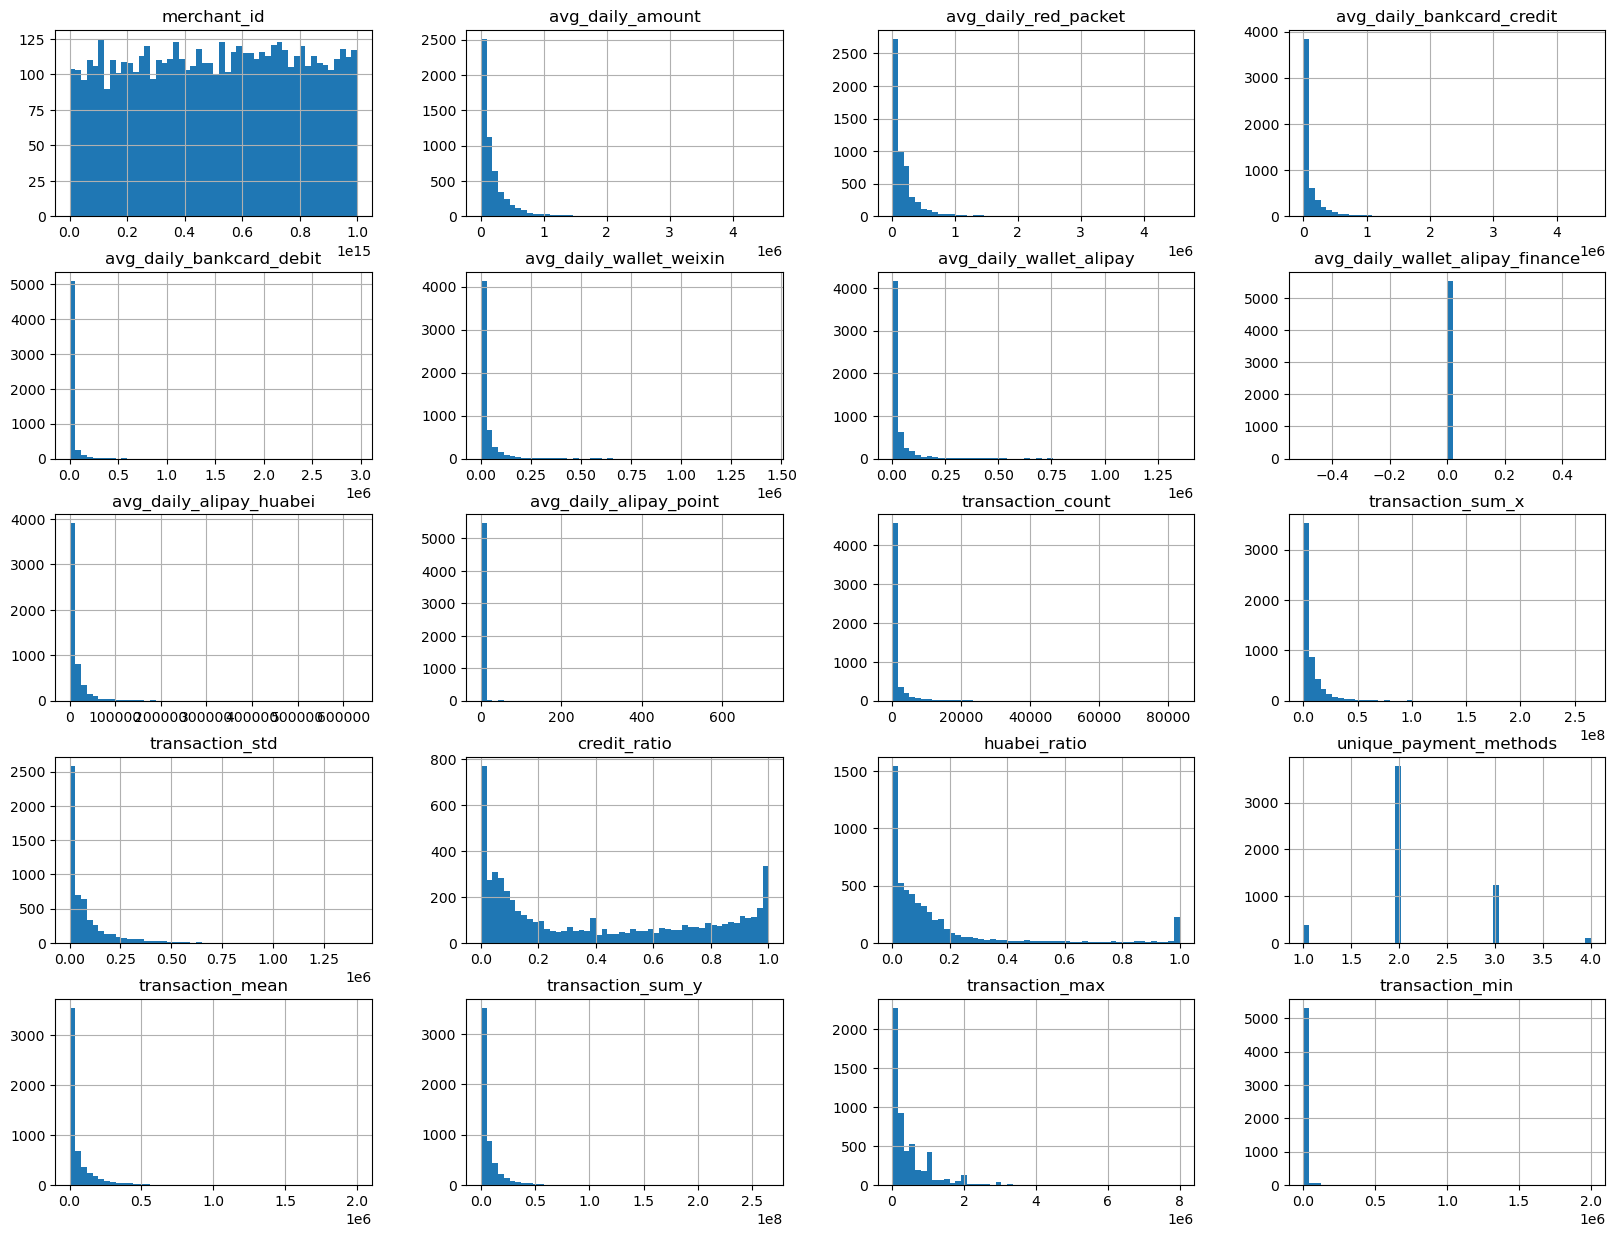

In [110]:
transaction_features.info()
transaction_features.hist(bins=50, figsize=(20, 15))
plt.show()
# loan_test.info()
# loan_test.hist(bins=50, figsize=(20, 15))
# plt.show()
# from pandas_profiling import ProfileReport

# profile = ProfileReport(transaction_data, title="Pandas Profiling Report", explorative=True)
# profile.to_file("transaction_data.html")


In [104]:
from sklearn.model_selection import train_test_split
# 合并交易数据
transaction_data = pd.concat([transaction_training, transaction_test, transaction_final], axis=0)
# 将 '\N' 替换为 NaN
transaction_data['paid_amount'].replace('\\N', pd.NA, inplace=True)

# 将列转换为数字类型
transaction_data['paid_amount'] = pd.to_numeric(transaction_data['paid_amount'])

# 检查转换后的数据类型和缺失值
# print(transaction_data['paid_amount'].dtype)
# print(transaction_data['paid_amount'].isna().sum())

# 处理历史还款数据
def preprocess_loan_data(df):
    df['apply_date'] = pd.to_datetime(df['apply_date'])
    df['notional_settle_date'] = pd.to_datetime(df['notional_settle_date'])
    df['real_settle_date'] = pd.to_datetime(df['real_settle_date'])
    return df

history_loan = preprocess_loan_data(history_loan)

# 特征提取
def extract_features(loan_data, history_data, transaction_data):
    features = loan_data[['apply_id', 'merchant_id', 'lend_amount', 'lend_period']].copy()

#     # 贷款次数
#     loan_counts = loan_data.groupby('merchant_id').size().reset_index(name='loan_count')
    combined_loan_data = pd.concat([loan_data, history_data], ignore_index=True)

    # 计算每个商户的贷款次数
    loan_counts = combined_loan_data.groupby('merchant_id').size().reset_index(name='loan_count')

    # 逾期30天还款现象的贷款交易数
#     overdue_counts = history_data[history_data['is_30days_overdue'] == 1].groupby('merchant_id').size().reset_index(name='overdue_count')

    # 未逾期还贷频率
#     non_overdue_counts = loan_data[loan_data['is_30days_overdue'] == 0].groupby('merchant_id').size().reset_index(name='non_overdue_count')

    # 实际还款和理论还款之间的天数差异
    history_data['settle_diff'] = (history_data['real_settle_date'] - history_data['notional_settle_date']).dt.days
    settle_diff_avg = history_data.groupby('merchant_id')['settle_diff'].mean().reset_index(name='settle_diff_avg')

    # 历史逾期率
    history_overdue_counts = history_data[history_data['is_30days_overdue'] == 1].groupby('merchant_id').size().reset_index(name='history_overdue_count')
    history_loan_counts = history_data.groupby('merchant_id').size().reset_index(name='history_loan_count')
    history_overdue_rate = pd.merge(history_overdue_counts, history_loan_counts, on='merchant_id', how='left')
    history_overdue_rate['history_overdue_rate'] = history_overdue_rate['history_overdue_count'] / history_overdue_rate['history_loan_count']

    # 计算重新逾期次数和未逾期次数
    history_data['recalculated_overdue'] = history_data.apply(lambda row: 1 if row['real_settle_date'] > row['notional_settle_date'] else 0, axis=1)
    recalculated_overdue_counts = history_data[history_data['recalculated_overdue'] == 1].groupby('merchant_id').size().reset_index(name='recalculated_overdue_count')
    recalculated_non_overdue_counts = history_data[history_data['recalculated_overdue'] == 0].groupby('merchant_id').size().reset_index(name='recalculated_non_overdue_count')

    # 商户逾期率与平均贷款期数的比值
    history_period_avg = history_data.groupby('merchant_id')['lend_period'].mean().reset_index(name='history_period_avg')
    history_overdue_rate = pd.merge(history_overdue_rate, history_period_avg, on='merchant_id', how='left')
    history_overdue_rate['overdue_rate_to_period'] = history_overdue_rate['history_overdue_rate'] / history_overdue_rate['history_period_avg']

    # 商户历史贷款总金额、历史平均贷款期数
    history_amount_sum = history_data.groupby('merchant_id')['lend_amount'].sum().reset_index(name='history_amount_sum')
    history_period_avg = history_data.groupby('merchant_id')['lend_period'].mean().reset_index(name='history_period_avg')

    # 每期应还款数
    loan_data['repayment_per_period'] = loan_data['lend_amount'] / loan_data['lend_period']

    # 还款金额统计特征
    repayment_stats = history_data.groupby('merchant_id')['lend_amount'].agg(['mean', 'sum', 'max', 'min']).reset_index()
    repayment_stats.columns = ['merchant_id', 'repayment_mean', 'repayment_sum', 'repayment_max', 'repayment_min']

    # 合并特征
    features = features.merge(loan_counts, on='merchant_id', how='left')
#     features = features.merge(overdue_counts, on='merchant_id', how='left')
#     features = features.merge(non_overdue_counts, on='merchant_id', how='left')
    features = features.merge(settle_diff_avg, on='merchant_id', how='left')
    features = features.merge(history_overdue_rate[['merchant_id', 'history_overdue_rate']], on='merchant_id', how='left')
    features = features.merge(recalculated_overdue_counts, on='merchant_id', how='left')
    features = features.merge(recalculated_non_overdue_counts, on='merchant_id', how='left')
    features = features.merge(history_overdue_rate[['merchant_id', 'overdue_rate_to_period']], on='merchant_id', how='left')
    features = features.merge(history_amount_sum, on='merchant_id', how='left')
    features = features.merge(history_period_avg, on='merchant_id', how='left')
    features = features.merge(repayment_stats, on='merchant_id', how='left')
    features = features.merge(loan_data[['apply_id', 'repayment_per_period']], on='apply_id', how='left')

#     features.fillna(0, inplace=True)
    features.fillna(features.mean(),inplace=True)

    return features



def extract_transaction_features(transaction_data):
    transaction_data['ctime'] = pd.to_datetime(transaction_data['ctime'], unit='ms')
    transaction_data['date'] = transaction_data['ctime'].dt.date
    
    # 商户平均每日消费者支付金额
    avg_daily_amount = transaction_data.groupby(['merchant_id', 'date'])['paid_amount'].sum().groupby('merchant_id').mean().reset_index(name='avg_daily_amount')
    
    # 商户平均每日红包金额
    avg_daily_red_packet = transaction_data[transaction_data['sub_pay_way'] == 3].groupby(['merchant_id', 'date'])['paid_amount'].sum().groupby('merchant_id').mean().reset_index(name='avg_daily_red_packet')
    
    # 支付方式的平均每日消费者支付金额
    payment_methods = ['bankcard_credit', 'bankcard_debit', 'wallet_weixin', 'wallet_alipay', 'wallet_alipay_finance', 'alipay_huabei', 'alipay_point']
    payment_features = []
    
    for method in payment_methods:
        avg_daily_payment = transaction_data.groupby(['merchant_id', 'date'])[method].sum().groupby('merchant_id').mean().reset_index(name=f'avg_daily_{method}')
        payment_features.append(avg_daily_payment)
    
    # 商户交易活动度
    transaction_activity = transaction_data.groupby('merchant_id')['paid_amount'].agg(['count', 'sum', 'std']).reset_index()
    transaction_activity.columns = ['merchant_id', 'transaction_count', 'transaction_sum', 'transaction_std']
    
    # 信用卡支付金额与总支付金额的比例
    credit_ratio = transaction_data.groupby('merchant_id')['bankcard_credit'].sum().reset_index(name='credit_sum')
    total_amount = transaction_data.groupby('merchant_id')['paid_amount'].sum().reset_index(name='total_sum')
    credit_ratio = credit_ratio.merge(total_amount, on='merchant_id', how='left')
    credit_ratio['credit_ratio'] = credit_ratio['credit_sum'] / credit_ratio['total_sum']
    
    # 花呗支付金额与总支付金额的比例
    huabei_ratio = transaction_data.groupby('merchant_id')['alipay_huabei'].sum().reset_index(name='huabei_sum')
    huabei_ratio = huabei_ratio.merge(total_amount, on='merchant_id', how='left')
    huabei_ratio['huabei_ratio'] = huabei_ratio['huabei_sum'] / huabei_ratio['total_sum']
    
    # 支付方式统计
    unique_payment_methods = transaction_data.groupby('merchant_id')['pay_way'].nunique().reset_index(name='unique_payment_methods')
    
    # 交易频率和金额统计特征
    transaction_stats = transaction_data.groupby('merchant_id')['paid_amount'].agg(['mean', 'sum', 'max', 'min']).reset_index()
    transaction_stats.columns = ['merchant_id', 'transaction_mean', 'transaction_sum', 'transaction_max', 'transaction_min']
    
    # 合并所有特征
    features = avg_daily_amount
    features = features.merge(avg_daily_red_packet, on='merchant_id', how='left')
    for payment_feature in payment_features:
        features = features.merge(payment_feature, on='merchant_id', how='left')
    features = features.merge(transaction_activity, on='merchant_id', how='left')
    features = features.merge(credit_ratio[['merchant_id', 'credit_ratio']], on='merchant_id', how='left')
    features = features.merge(huabei_ratio[['merchant_id', 'huabei_ratio']], on='merchant_id', how='left')
    features = features.merge(unique_payment_methods, on='merchant_id', how='left')
    features = features.merge(transaction_stats, on='merchant_id', how='left')
    
#     features.fillna(0, inplace=True)
    features.fillna(features.mean(),inplace=True)
    
    return features

# 提取特征
loan_features = extract_features(loan_train, history_loan, transaction_data)

# 添加目标变量
loan_features = loan_features.merge(loan_train[['apply_id', 'is_30days_overdue']], on='apply_id', how='left')

# 提取交易流水特征
transaction_features = extract_transaction_features(transaction_data)

# 合并贷款和交易流水特征
final_features = loan_features.merge(transaction_features, on='merchant_id', how='left')

# 填充缺失值
final_features.fillna(0, inplace=True)

# 划分训练集和验证集
X = final_features.drop(columns=['apply_id', 'merchant_id', 'is_30days_overdue'])
y = final_features['is_30days_overdue']


# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
# 提取测试集特征
loan_features = extract_features(loan_test, history_loan, transaction_data)

final_features = loan_features.merge(transaction_features, on='merchant_id', how='left')

# final_features.fillna(0, inplace=True)
final_features.fillna(final_features.mean(),inplace=True)

X_test = final_features.drop(columns=['apply_id', 'merchant_id'])

In [106]:
# 使用多种分类模型进行分类任务
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
# from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score
# 模型列表
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
#     "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "RandomForest":RandomForestClassifier(random_state=42),
    "MLP":MLPClassifier(random_state=42)
}
result_list=[]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# 训练和验证
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    result_list.append(y_pred)
    print(f"{model_name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
#     print(model_name)
#     print(classification_report(y_val, y_pred))

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Logistic Regression - Accuracy: 0.6167, F1 Score: 0.4651


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


SVM - Accuracy: 0.5958, F1 Score: 0.4921
XGBoost - Accuracy: 0.6625, F1 Score: 0.5668
CatBoost - Accuracy: 0.7167, F1 Score: 0.6180


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


RandomForest - Accuracy: 0.6792, F1 Score: 0.5746
MLP - Accuracy: 0.7000, F1 Score: 0.5955


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


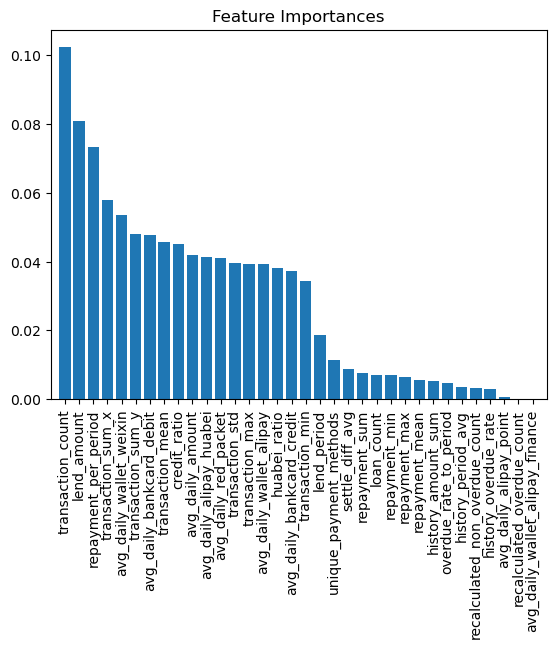

In [92]:
model=models['RandomForest']
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
# 进行预测并保存结果
for model_name, model in models.items():
    test_predictions = model.predict(X_test)
    results = pd.DataFrame({'apply_id': loan_test['apply_id'], 'is_30days_overdue': test_predictions})
    results.to_csv(f'{model_name}_predictions.txt', index=False)

In [107]:
# 使用神经网络进行分类
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

# 读取数据
# 假设 final_features 是已提取的特征数据集，包含目标变量 'is_30days_overdue'
# X = final_features.drop(columns=['merchant_id', 'is_30days_overdue'])
# y = final_features['is_30days_overdue']

# 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)
# X=pd.DataFrame(X)
# y=pd.DataFrame(y)

# 数据拆分
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train = X_train.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)

# 自定义数据集
class LoanDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = np.array(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
#         print(self.X,self.y)
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)
# X_train=pd.DataFrame(X_train)
# y_train=pd.DataFrame(y_train)
# X_val=pd.DataFrame(X_val)
# y_val=pd.DataFrame(y_val)
train_dataset = LoanDataset(X_train, y_train)
val_dataset = LoanDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 定义神经网络
class LoanClassifier(nn.Module):
    def __init__(self, input_dim):
        super(LoanClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# 初始化模型、损失函数和优化器
input_dim = X.shape[1]
model = LoanClassifier(input_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 20
best_val_accuracy = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        outputs = model(X_batch)
#         print(outputs.shape,y_batch.shape)
        loss = criterion(outputs, y_batch.view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.view(-1))
            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}')

# # 测试数据预测
# loan_test_features = extract_loan_features(loan_test, history_loan_data)
# final_test_features = loan_test_features.merge(transaction_features, on='merchant_id', how='left')
# final_test_features = final_test_features.merge(merchant_data, on='merchant_id', how='left')
# X_test = scaler.transform(final_test_features.drop(columns=['merchant_id']))

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

X_test = scaler.transform(X_test)

X_test_tensor = torch.tensor(np.array(X_test), dtype=torch.float32)
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_preds = torch.max(test_outputs, 1)

results = pd.DataFrame({'apply_id': loan_test['apply_id'],'merchant_id': loan_test['merchant_id'],'apply_date': loan_test['apply_date'],'lend_amount': loan_test['lend_amount'],'lend_period': loan_test['lend_period'], 'is_30days_overdue': test_preds.cpu().numpy()})
results.to_csv('pytorch_predictions.txt', index=False)


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Epoch 1/20, Train Loss: 0.6579, Val Loss: 0.6513, Val Accuracy: 0.6333, Val F1: 0.0222
Epoch 2/20, Train Loss: 0.6321, Val Loss: 0.6256, Val Accuracy: 0.6625, Val F1: 0.4490
Epoch 3/20, Train Loss: 0.6032, Val Loss: 0.6220, Val Accuracy: 0.6542, Val F1: 0.4430
Epoch 4/20, Train Loss: 0.5857, Val Loss: 0.6082, Val Accuracy: 0.6625, Val F1: 0.5091
Epoch 5/20, Train Loss: 0.5801, Val Loss: 0.5899, Val Accuracy: 0.6750, Val F1: 0.5357
Epoch 6/20, Train Loss: 0.5656, Val Loss: 0.5890, Val Accuracy: 0.6750, Val F1: 0.5761
Epoch 7/20, Train Loss: 0.5794, Val Loss: 0.5822, Val Accuracy: 0.6875, Val F1: 0.5614
Epoch 8/20, Train Loss: 0.5635, Val Loss: 0.5795, Val Accuracy: 0.6917, Val F1: 0.6022
Epoch 9/20, Train Loss: 0.5652, Val Loss: 0.5669, Val Accuracy: 0.6917, Val F1: 0.5889
Epoch 10/20, Train Loss: 0.5564, Val Loss: 0.5588, Val Accuracy: 0.6958, Val F1: 0.5922
Epoch 11/20, Train Loss: 0.5600, Val Loss: 0.5601, Val Accuracy: 0.6917, Val F1: 0.5843
Epoch 12/20, Train Loss: 0.5550, Val Loss

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Overdue', 'Overdue'], yticklabels=['Not Overdue', 'Overdue'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()
    
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_proba, title):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_proba, title):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.show()

def plot_training_curves(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.show()


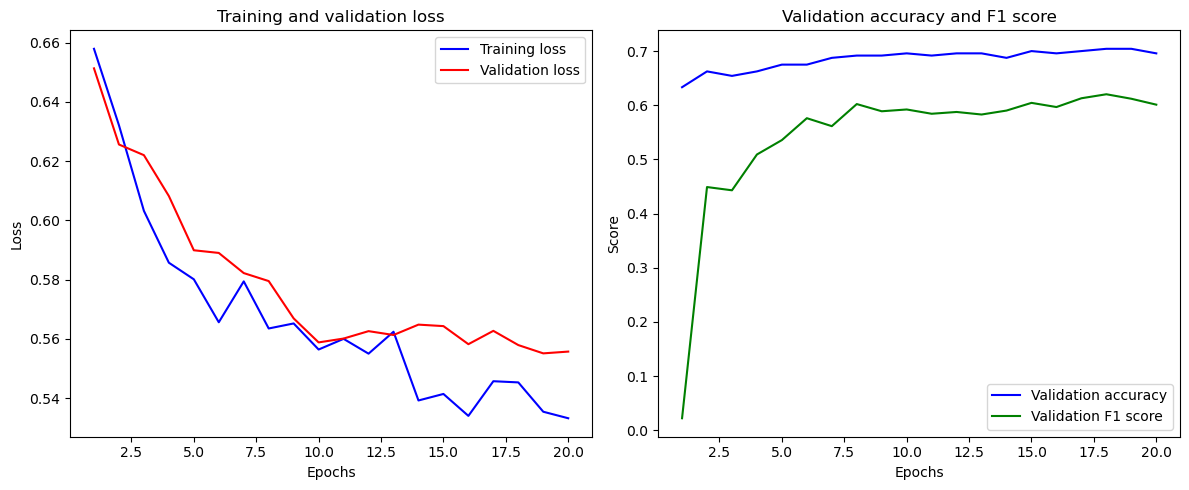

In [115]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses, val_accuracies, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)
    
    # Plot losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracies and F1 scores
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
    plt.plot(epochs, val_f1_scores, 'g', label='Validation F1 score')
    plt.title('Validation accuracy and F1 score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Provided data
train_losses = [0.6579, 0.6321, 0.6032, 0.5857, 0.5801, 0.5656, 0.5794, 0.5635, 0.5652, 0.5564, 0.5600, 0.5550, 0.5624, 0.5392, 0.5414, 0.5340, 0.5457, 0.5453, 0.5354, 0.5332]
val_losses = [0.6513, 0.6256, 0.6220, 0.6082, 0.5899, 0.5890, 0.5822, 0.5795, 0.5669, 0.5588, 0.5601, 0.5626, 0.5613, 0.5648, 0.5643, 0.5582, 0.5627, 0.5579, 0.5551, 0.5557]
val_accuracies = [0.6333, 0.6625, 0.6542, 0.6625, 0.6750, 0.6750, 0.6875, 0.6917, 0.6917, 0.6958, 0.6917, 0.6958, 0.6958, 0.6875, 0.7000, 0.6958, 0.7000, 0.7042, 0.7042, 0.6958]
val_f1_scores = [0.0222, 0.4490, 0.4430, 0.5091, 0.5357, 0.5761, 0.5614, 0.6022, 0.5889, 0.5922, 0.5843, 0.5876, 0.5829, 0.5902, 0.6044, 0.5967, 0.6129, 0.6203, 0.6120, 0.6011]

# Plot training curves
plot_training_curves(train_losses, val_losses, val_accuracies, val_f1_scores)


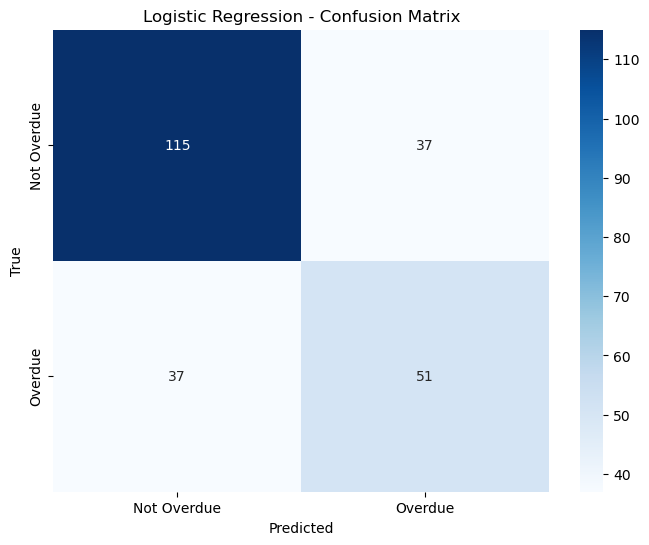

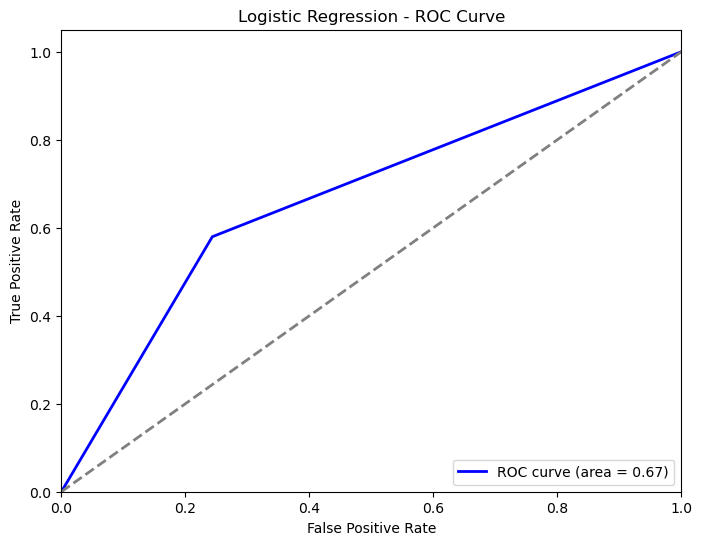

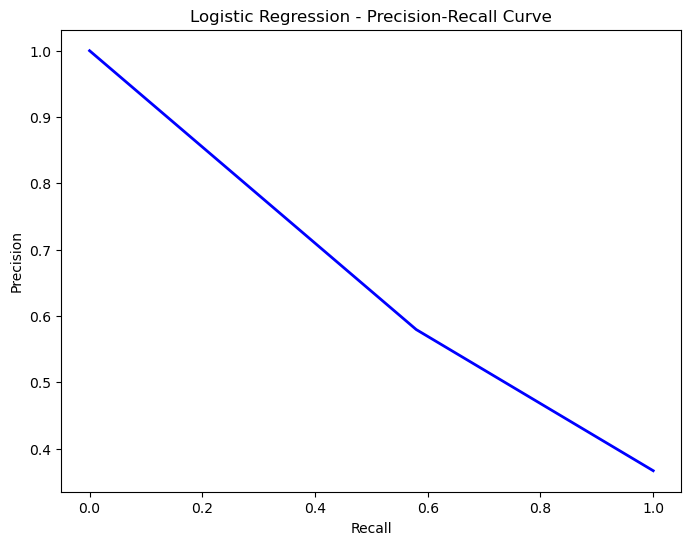

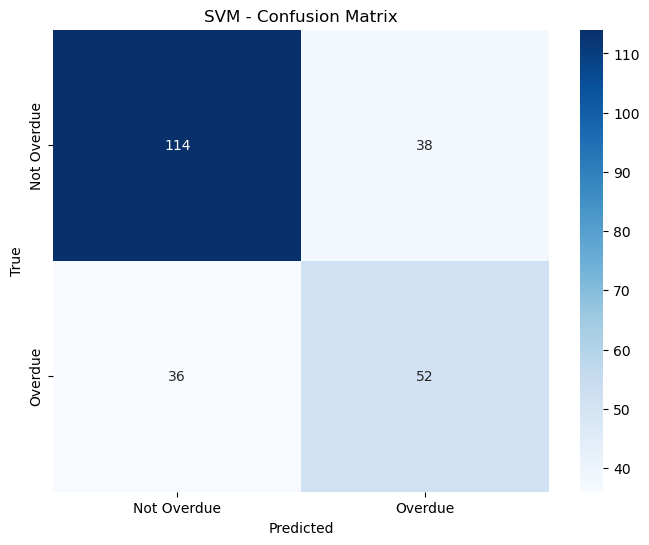

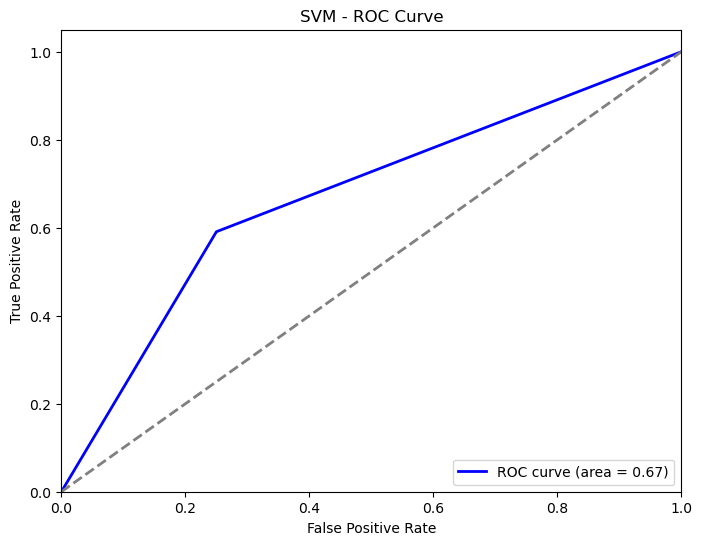

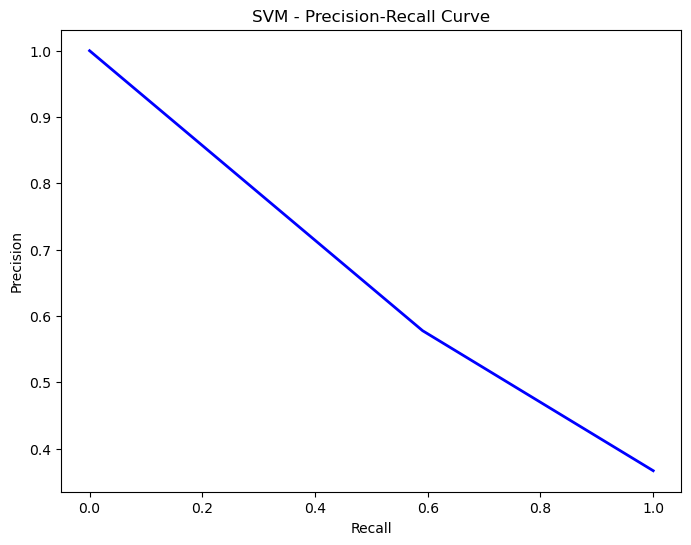

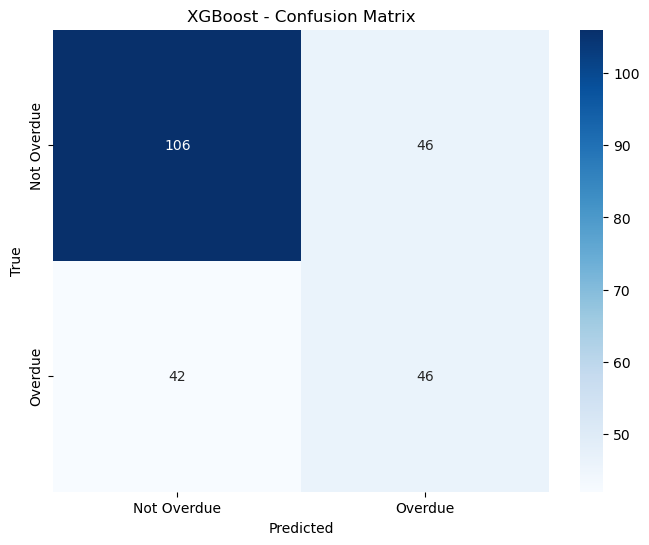

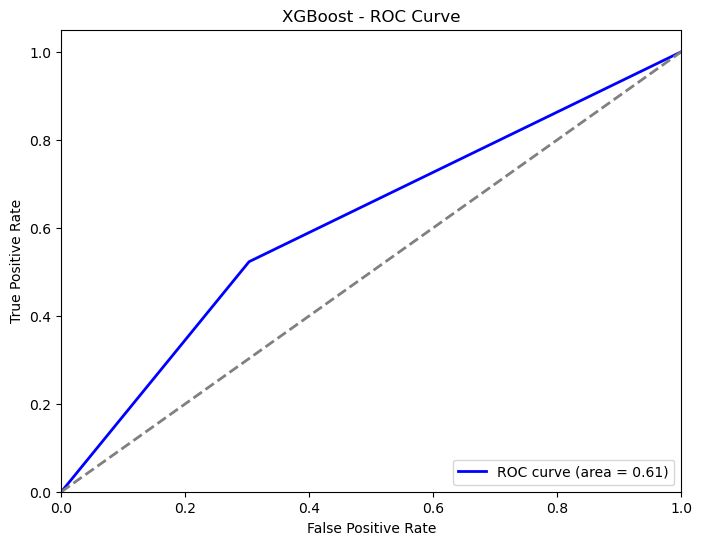

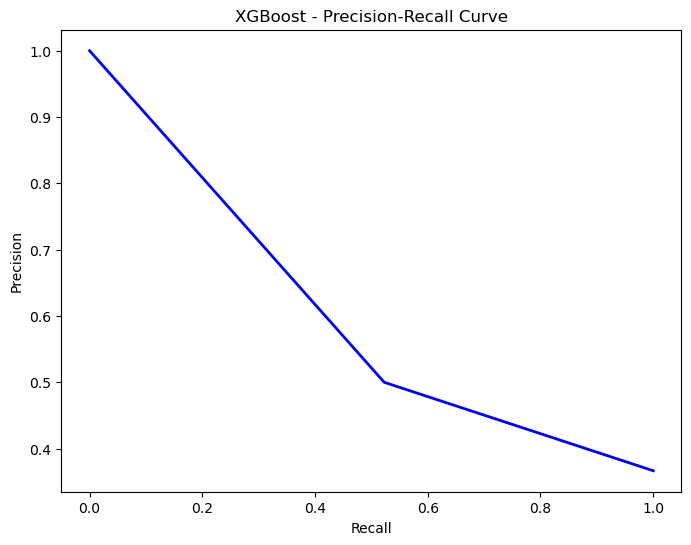

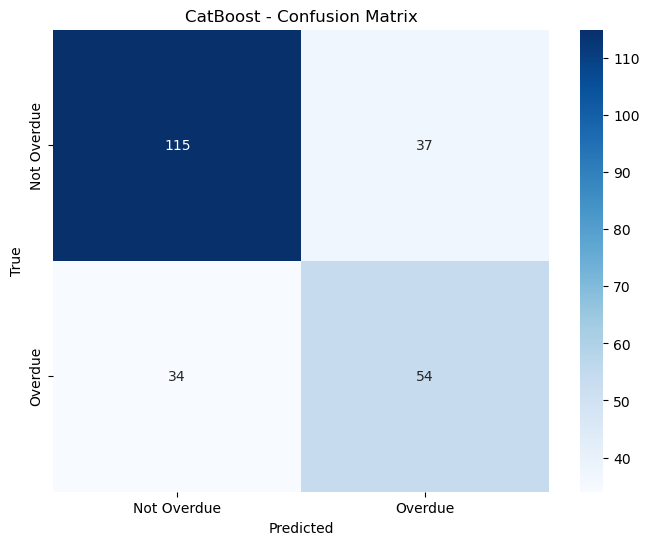

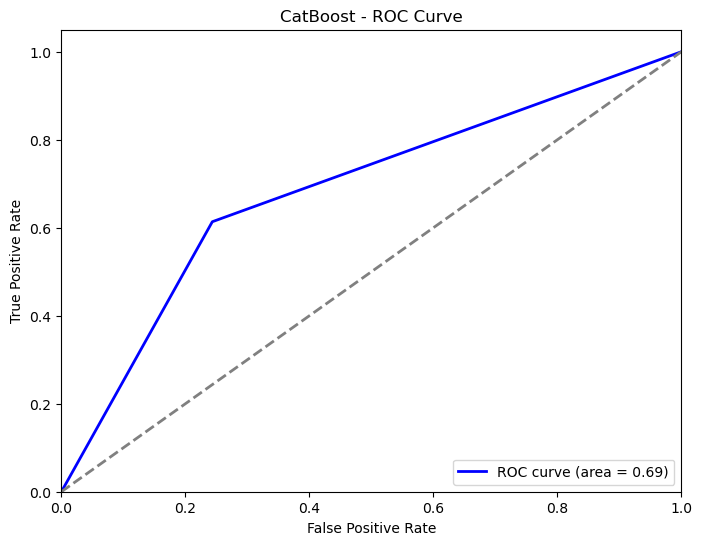

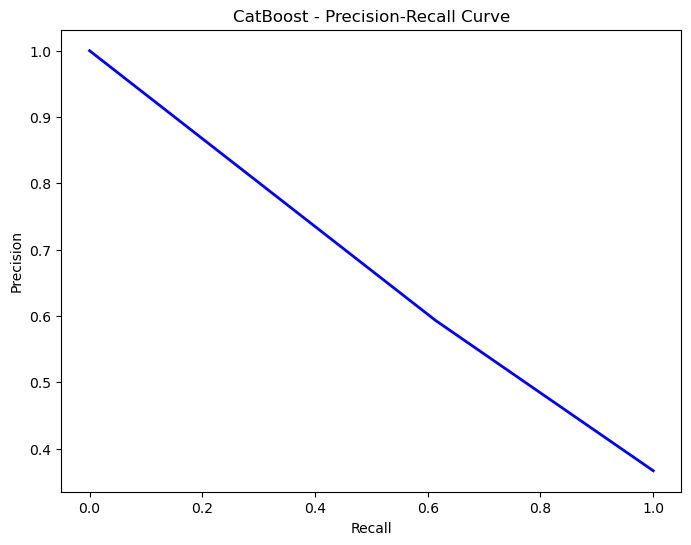

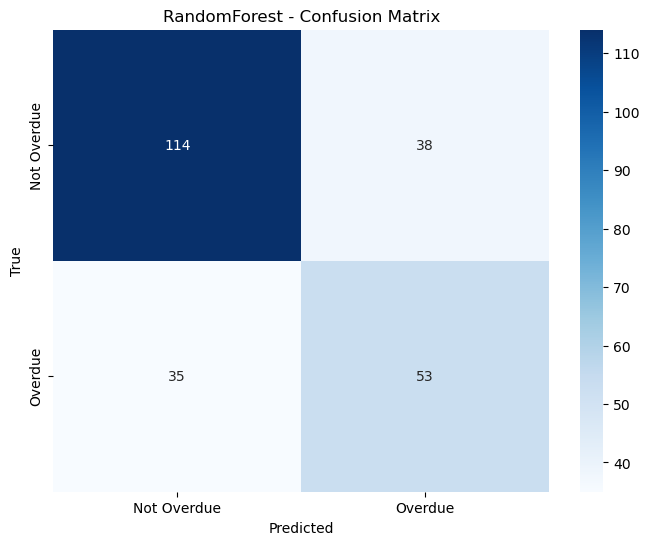

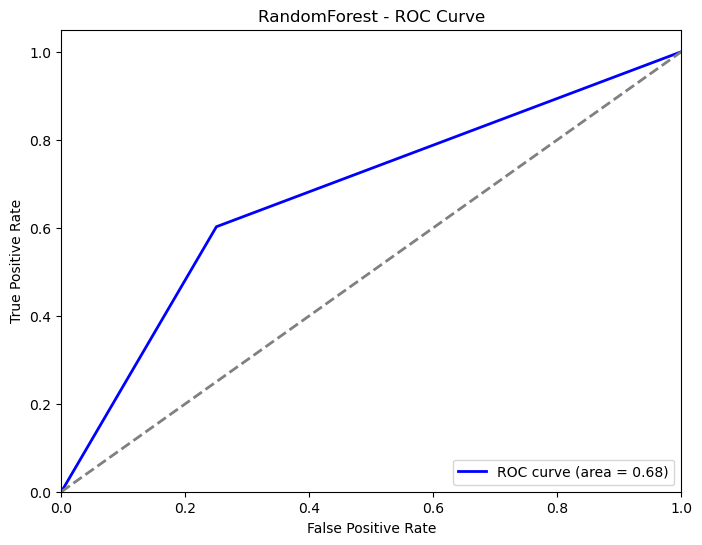

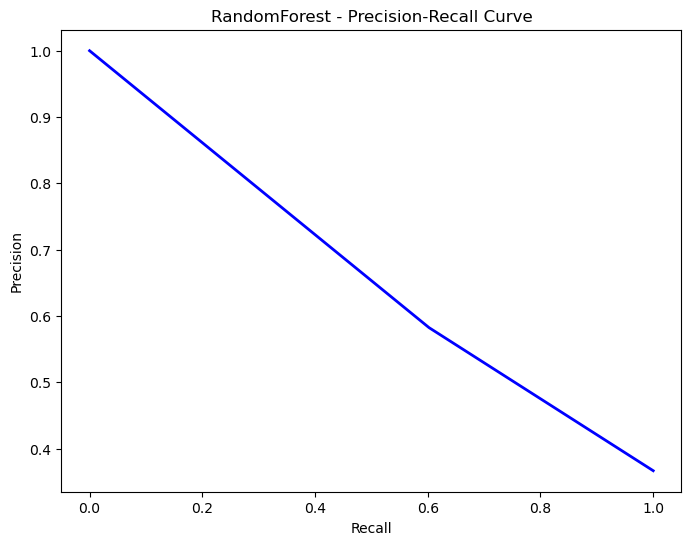

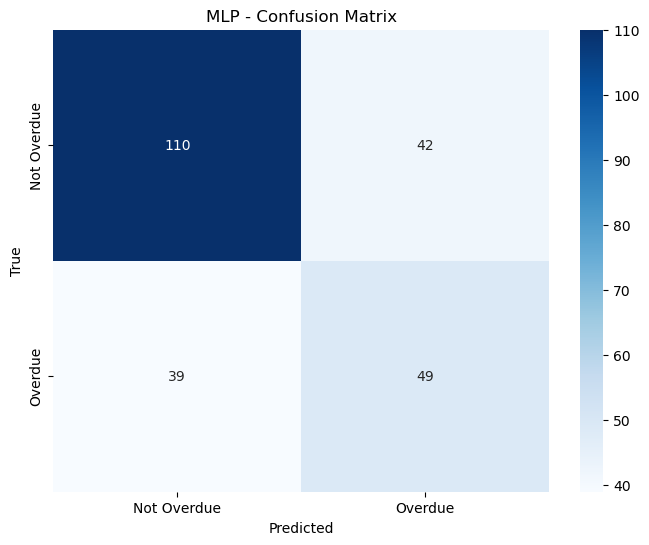

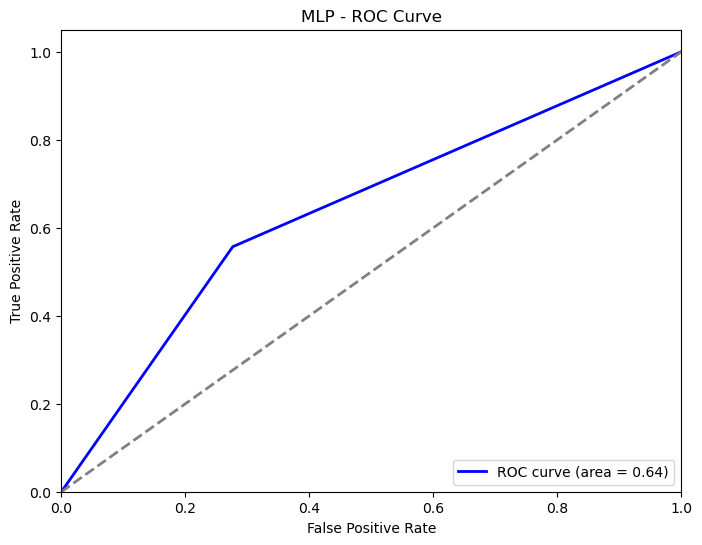

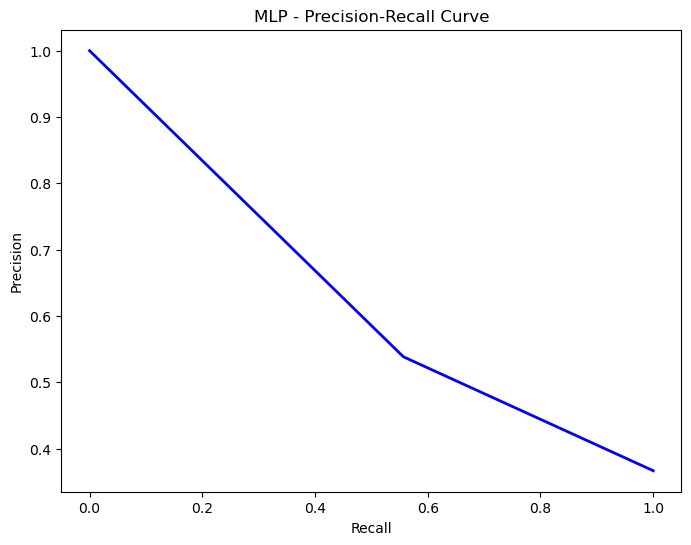

In [78]:
i=0

for model_name, model in models.items():
    # 绘制混淆矩阵
    plot_confusion_matrix(y_val, result_list[i], title=f"{model_name} - Confusion Matrix")

    # 绘制ROC曲线
    plot_roc_curve(y_val, result_list[i], title=f"{model_name} - ROC Curve")

    # 绘制精确率-召回率曲线
    plot_precision_recall_curve(y_val, result_list[i], title=f"{model_name} - Precision-Recall Curve")
    i+=1


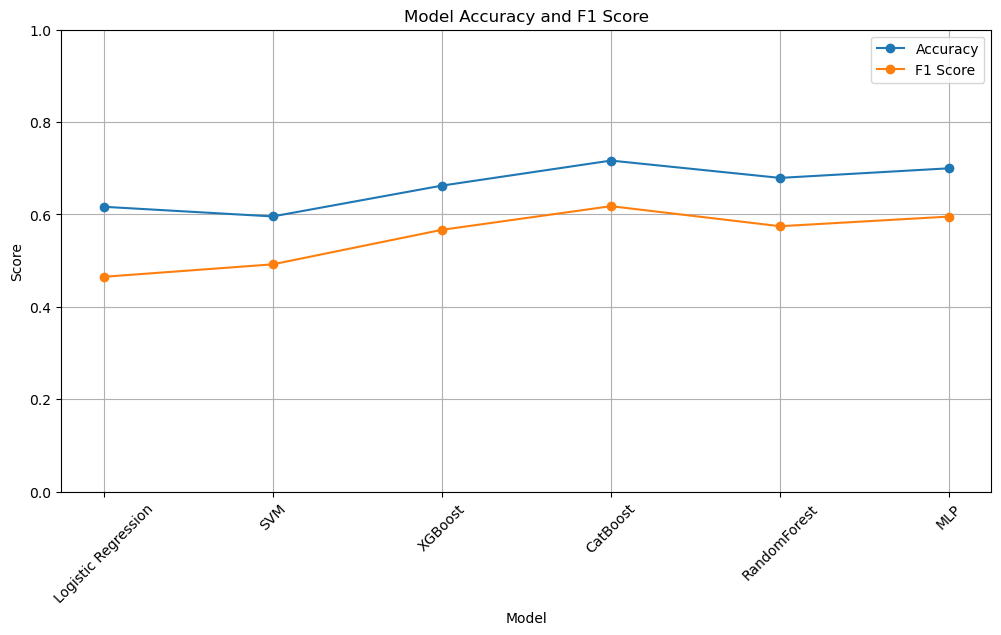

In [114]:
import matplotlib.pyplot as plt
import pandas as pd

# 准确率和 F1 分数数据
data = {
    'Model': ['Logistic Regression', 'SVM', 'XGBoost', 'CatBoost', 'RandomForest', 'MLP'],
    'Accuracy': [0.6167, 0.5958, 0.6625, 0.7167, 0.6792, 0.7000],
    'F1 Score': [0.4651, 0.4921, 0.5668, 0.6180, 0.5746, 0.5955]
}

# 创建 DataFrame
df = pd.DataFrame(data)

# 绘制折线图
plt.figure(figsize=(12, 6))
plt.plot(df['Model'], df['Accuracy'], marker='o', label='Accuracy')
plt.plot(df['Model'], df['F1 Score'], marker='o', label='F1 Score')
plt.title('Model Accuracy and F1 Score')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [109]:
# 将所有数据进行训练和预测
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

# 读取数据
# 假设 final_features 是已提取的特征数据集，包含目标变量 'is_30days_overdue'
# X = final_features.drop(columns=['merchant_id', 'is_30days_overdue'])
# y = final_features['is_30days_overdue']

# 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)
# X=pd.DataFrame(X)
# y=pd.DataFrame(y)

# 数据拆分
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train = X_train.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)

# 自定义数据集
class LoanDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = np.array(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
#         print(self.X,self.y)
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)
# X_train=pd.DataFrame(X_train)
# y_train=pd.DataFrame(y_train)
# X_val=pd.DataFrame(X_val)
# y_val=pd.DataFrame(y_val)
train_dataset = LoanDataset(X, y)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# 定义神经网络
class LoanClassifier(nn.Module):
    def __init__(self, input_dim):
        super(LoanClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# 初始化模型、损失函数和优化器
input_dim = X.shape[1]
model = LoanClassifier(input_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 18
best_val_accuracy = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        outputs = model(X_batch)
#         print(outputs.shape,y_batch.shape)
        loss = criterion(outputs, y_batch.view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()

    

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}')

# # 测试数据预测
# loan_test_features = extract_loan_features(loan_test, history_loan_data)
# final_test_features = loan_test_features.merge(transaction_features, on='merchant_id', how='left')
# final_test_features = final_test_features.merge(merchant_data, on='merchant_id', how='left')
# X_test = scaler.transform(final_test_features.drop(columns=['merchant_id']))

# model.load_state_dict(torch.load('best_model.pth'))
model.eval()

X_test = scaler.transform(X_test)

X_test_tensor = torch.tensor(np.array(X_test), dtype=torch.float32)
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_preds = torch.max(test_outputs, 1)

results = pd.DataFrame({'apply_id': loan_test['apply_id'],'merchant_id': loan_test['merchant_id'],'apply_date': loan_test['apply_date'],'lend_amount': loan_test['lend_amount'],'lend_period': loan_test['lend_period'], 'is_30days_overdue': test_preds.cpu().numpy()})
results.to_csv('pytorch_predictions.txt', index=False)


Epoch 1/18, Train Loss: 0.6565
Epoch 2/18, Train Loss: 0.6198
Epoch 3/18, Train Loss: 0.5938
Epoch 4/18, Train Loss: 0.5878
Epoch 5/18, Train Loss: 0.5820
Epoch 6/18, Train Loss: 0.5667
Epoch 7/18, Train Loss: 0.5748
Epoch 8/18, Train Loss: 0.5548
Epoch 9/18, Train Loss: 0.5595
Epoch 10/18, Train Loss: 0.5636
Epoch 11/18, Train Loss: 0.5595
Epoch 12/18, Train Loss: 0.5568
Epoch 13/18, Train Loss: 0.5574
Epoch 14/18, Train Loss: 0.5522
Epoch 15/18, Train Loss: 0.5512
Epoch 16/18, Train Loss: 0.5403
Epoch 17/18, Train Loss: 0.5390
Epoch 18/18, Train Loss: 0.5388
